In [49]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale = 1)
import os
import pandas as pd

import math
from pytorch_pretrained_bert import BertTokenizer
os.chdir('C:\\Users\\ntaylor\\Documents\\GitHub\\Neural_Networks\\NLP\\clinicalBERT')
from modeling_readmission import BertForSequenceClassification, BertForSequenceClassification_3layer
import modeling_readmission

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

05/18/2021 13:48:04 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\ntaylor\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


'C:\\Users\\ntaylor\\Documents\\GitHub\\Neural_Networks\\NLP\\clinicalBERT'

In [23]:

model_1layer_discharge_config_path = "./model/newest_ClinicalBERTPretained_discharge_210421/config.json"
model_1layer_discharge_model_path = "./model/newest_ClinicalBERTPretained_discharge_210421/pytorch_model.bin"

model_3layer_discharge_config_path = "./model/newest_3layerClinicalBERTPretained_discharge_210421/config.json"
model_3layer_discharge_model_path = "./model/newest_3layerClinicalBERTPretained_discharge_210421/pytorch_model.bin"

In [16]:
# #load 1layer model
bert_config = modeling_readmission.BertConfig.from_json_file(model_1layer_discharge_config_path)
# model = BertForSequenceClassification(bert_config, num_labels = 1)

# #load 3layer model
# bert_config = modeling_readmission.BertConfig.from_json_file(model_3layer_discharge_config_path)
model = BertForSequenceClassification_3layer(bert_config, num_labels = 1)

In [17]:
bert_config

{
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [18]:
print(model)

BertForSequenceClassification_3layer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
           

In [19]:
bert_config.num_attention_heads

12

In [24]:
dicts=model.load_state_dict(torch.load(model_3layer_discharge_model_path))

In [25]:
dicts

<All keys matched successfully>

In [13]:
model.bert.encoder.layer[0].attention.self

BertSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [5]:
def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [6]:
def get_attention_scores(model,i,text):
    tokenized=tokenizer.tokenize(text)

    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)

    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.bert.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.bert.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(bert_config,outputs_query[0])
    key_layer = transpose_for_scores(bert_config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(bert_config.hidden_size / bert_config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs,tokenized

In [112]:
text='has experienced acute on chronic diastolic heart failure in the setting of volume overload due to his sepsis prescribed warfarin due to high sys blood pressure 160 '

#below text is the best performing true positive case from selector-predictor model
# text = 'No evidence of infection still on cxr or blood cultures to date bp improved and metoprolol restarted at low dose to be uptitrated as tolerated and blood cultures pending at discharge afib with rvr has h o failed cardioversion cardiology consulted and recommended medical management he is not on coumadin fall risk but continued on asirin 325mg po daily rate control between 80s and 100s was achieved with digoxin 125mg po qod and metoprolol 25mg tid however metoprolol discontinued and then restarted at lower dose of 5mg in setting of lower running bp would increase beta blockade for more optimal rate control as bp tolerates hypoglycemia on am the patient had a bg of 37 improved to 190 on fs after amp d unclear etiology he is not diabetic and on no meds which would cause hypoglyemia no signs of infection pt had been receiving prednisone in am but changed to qhs dosing as this has helped him avoid late evening and early am hypoglycemic episodes in the past continue evening snacks and qid fsg monitoring obesity hypoventilation syndrome questionable history of obesity hypoventilation syndrome abg showed respiratory acidosis with 10 89 50 but hypercarbia improved on vbg of 39 50 could consider outpatient pulmonary evaluation of hypercapnia pvd s p lma revision no evidence of infection on arrival to the floor vancomycin and zosyn discontinued on given the negative cultures pt to continue wound vac until re evaluation by doctor he was continued on asa and plavix course to be determined by surgery pain controlled with tylenol and oral morphine follow up scheduled with doctor on at 10am right arm pain c o right arm pain over the last few weeks after being pulled by the right arm rue doppler u s was done and negative for a dvt pain contrlled with prn pain meds phyical therapy anemia likely esrd receives epo with'
x,tokens=get_attention_scores(model,0,text)
# print(x)
# print(tokens)

In [113]:
map1=np.asarray(x[0][1].detach().numpy())
len(tokens)

34

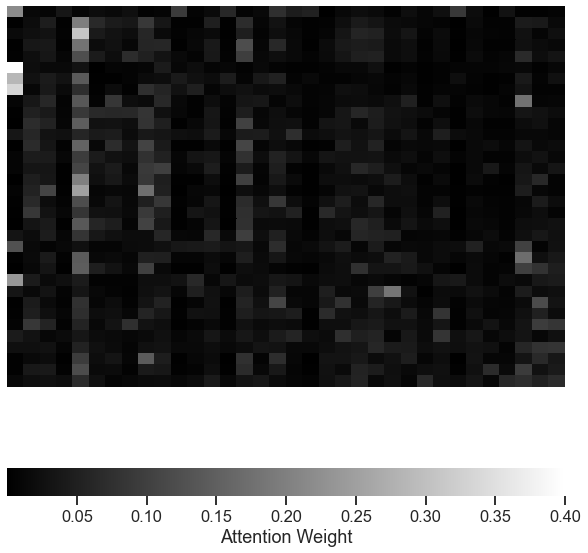

In [76]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight', 'orientation':'horizontal'}, rasterized = True)

<Figure size 432x288 with 0 Axes>

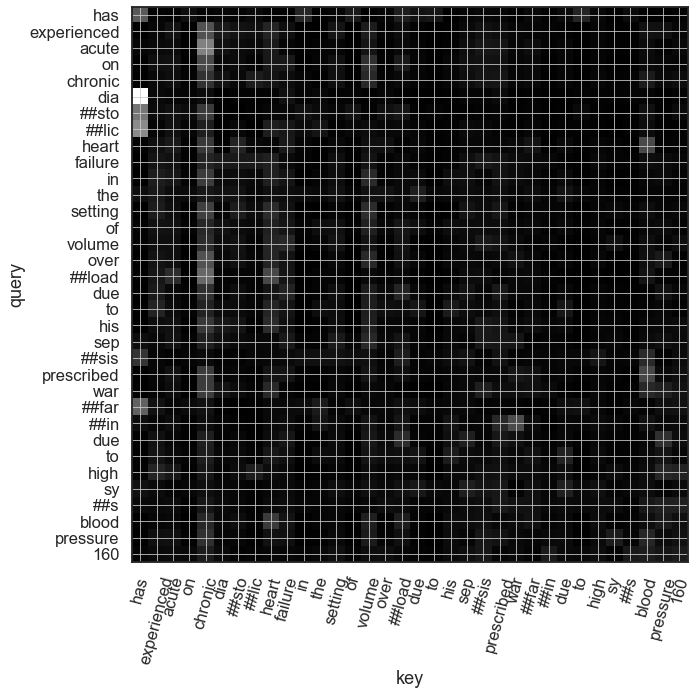

In [90]:
plt.clf()

f=plt.figure(figsize=(11,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1,interpolation='nearest',cmap='gray')

ax.set_yticks(range(len(tokens)))
ax.set_yticklabels(tokens)

ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens,rotation=75)

ax.set_xlabel('key')
ax.set_ylabel('query')

ax.grid(linewidth = 0.8)
plt.tight_layout()

plt.savefig("./results/result_newest_3layerClinicalBERTPretrained_discharge_210421_v2/attention_weights.png")

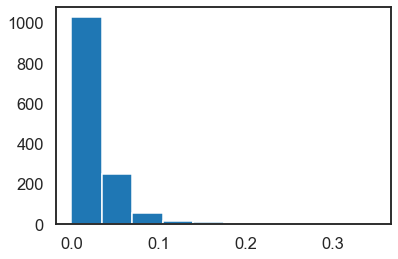

In [64]:
plt.hist(map1.flatten());

In [65]:
# fig, ax = plt.subplots(figsize = (8,6))

# # Plot
#     # Plot histogram
# prop_chosen.plot(kind = "hist", density = True, alpha = 0.65, bins = 15) # change density to true, because KDE uses density
#     # Plot KDE
# prop_chosen.plot(kind = "kde")

#     # Quantile lines
# quant_5, quant_25, quant_50, quant_75, quant_95 = prop_chosen.quantile(0.05), prop_chosen.quantile(0.25), prop_chosen.quantile(0.5), prop_chosen.quantile(0.75), prop_chosen.quantile(0.95)
# quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]
# for i in quants:
#     ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")


# # X
# ax.set_xlabel("Average Proportion Chosen")
#     # Limit x range to 0-4
# x_start, x_end = 0, 1
# ax.set_xlim(x_start, x_end)

# # Y
# # ax.set_ylim(0, 1)
# ax.set_yticklabels([])
# ax.set_ylabel("")

# # Annotations
# ax.text(quant_5-0.01, 0.6, "5th", size = 10, alpha = 0.8)
# ax.text(quant_25-0.02, 1.1, "25th", size = 11, alpha = 0.85)
# ax.text(quant_50-0.03, 1.5, "50th", size = 12, alpha = 1)
# ax.text(quant_75-0.03, 2, "75th", size = 11, alpha = 0.85)
# ax.text(quant_95-0.1, 2.6, "95th Percentile", size = 10, alpha =.8)

# # Overall
# ax.grid(False)
# ax.set_title("Rationales - Proportion of raw sentence", size = 17, pad = 10)

#     # Remove ticks and spines
# ax.tick_params(left = False, bottom = False)
# for ax, spine in ax.spines.items():
#     spine.set_visible(False)

In [108]:
map1

array([[0.21828909, 0.01280007, 0.00879827, ..., 0.00475543, 0.00345628,
        0.00765487],
       [0.00194712, 0.01916759, 0.04556718, ..., 0.04259956, 0.03993243,
        0.01556106],
       [0.01636472, 0.02365707, 0.02863437, ..., 0.02794952, 0.00829373,
        0.02410257],
       ...,
       [0.00465461, 0.01527393, 0.01967498, ..., 0.03192343, 0.06471989,
        0.03730422],
       [0.00446331, 0.03805333, 0.03990122, ..., 0.09317885, 0.02809204,
        0.04141293],
       [0.01302321, 0.02320081, 0.026464  , ..., 0.07120138, 0.05252729,
        0.06737187]], dtype=float32)

In [114]:
mask = np.where(map1>0.16)
map1[mask]

array([0.22178552, 0.34186354, 0.16099222, 0.7384544 , 0.19812451,
       0.3007973 , 0.20604111, 0.1960718 , 0.18992655, 0.30754218,
       0.25184155, 0.21445379, 0.4055475 , 0.19186366, 0.1641905 ,
       0.35834438, 0.17874883, 0.20844562, 0.271464  , 0.26135364],
      dtype=float32)

In [105]:
mask

(array([ 0,  1,  2,  3,  5,  6,  7,  8, 15, 16, 16, 22, 24, 25],
       dtype=int64),
 array([ 0,  4,  4,  4,  0,  0,  0, 31,  4,  4,  8, 31,  0, 23],
       dtype=int64))

In [106]:
np.array(tokens)[mask[0]]

array(['has', 'experienced', 'acute', 'on', 'dia', '##sto', '##lic',
       'heart', 'over', '##load', '##load', 'prescribed', '##far', '##in'],
      dtype='<U11')

In [107]:
np.array(tokens)[mask[1]]

array(['has', 'chronic', 'chronic', 'chronic', 'has', 'has', 'has',
       'blood', 'chronic', 'chronic', 'heart', 'blood', 'has', 'war'],
      dtype='<U11')

<Figure size 432x288 with 0 Axes>

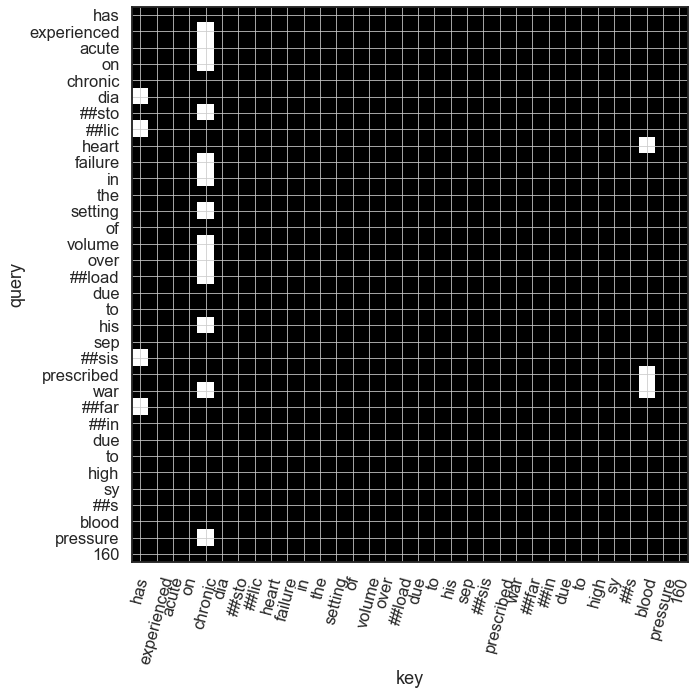

In [118]:
# find the key/queries with attention weights above a certain threshold
map1_bool = (map1>0.16).astype(int)
plt.clf()

f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1_bool,interpolation='nearest',cmap='gray')

ax.set_yticks(range(len(tokens)))
ax.set_yticklabels(tokens)

ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens,rotation=75)

ax.set_xlabel('key')
ax.set_ylabel('query')

ax.grid(linewidth = 0.8)
plt.tight_layout()

plt.savefig("./results/result_newest_3layerClinicalBERTPretrained_discharge_210421_v2/attention_weights_bool.png")

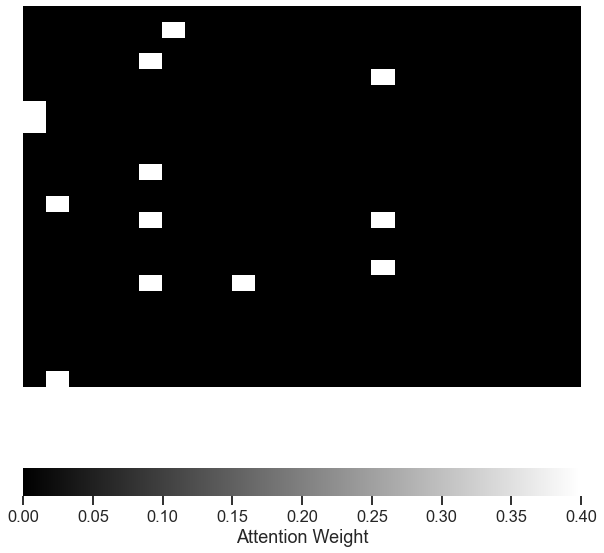

In [44]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(map1_bool, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight', 'orientation':'horizontal'}, rasterized = True)

In [31]:
# can get index of map for tokens with highest weights
map1.shape

(24, 24)

In [109]:
text = 'confidential notes from mimic iii'
x,tokens=get_attention_scores(model,0,text)
map2=np.asarray(x[0][1].detach().numpy())

Text(68.0, 0.5, 'Query Tokens')

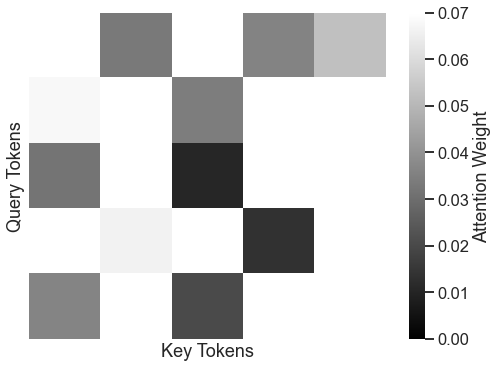

In [110]:
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(map2, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmin=0, vmax=0.07, cmap='gray', cbar_kws={'label':'Attention Weight'})

ax.set_xlabel('Key Tokens')
ax.set_ylabel('Query Tokens')